This file is part of DEAP.

DEAP is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

DEAP is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License along with DEAP. If not, see <http://www.gnu.org/licenses/>.


https://github.com/DEAP/deap/blob/d328fe6b68e7528b2d2d990bb2ab1ad1786e6f58/examples/ga/onemax.py
example which maximizes the sum of a list of integers
each of which can be 0 or 1


# Imports

## DEAP base

In [1]:
!pip install deap
import random

from deap import base
from deap import creator
from deap import tools


/bin/sh: 1: pip: not found


## Custom

In [2]:
import array
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt


# FI Config

## Lien's bisection algorithm

In [3]:
def bisectionLien(F,W,epsilon=0.000001):
    """
    Simple algorithm for identifying λ-value for fuzzy measures and fuzzy 
    integrals (Chung-Chang Lien & Chie-Bein Chen)
    
    https://doi.org/10.1080/09720510.2007.10701271
    
    :param F: F(lambda)
    :param W: fuzzy measure
    :param epsilon: precision for te aproximation to F(lambda) = 0
    
    :rtype: lambda that makes F(lambda)=0 with given measure
    """
    F1 = sum(W)
    if F1 == 1:
        return 0
    elif F1 > 1:
        p = -1
        m = 0
    elif F1 < 1:
        p = 1
        m = 0
        while F(p,W) < 0:
            m = p
            p = p * 2
    F2 = F((p + m) / 2,W)
    while abs(F2) > epsilon:
        if F2 > 0:
            p = ( p + m )/ 2
        elif  F2 < 0:
            m = ( p + m )/ 2
        F2 = F((p + m) / 2,W)
    return (p + m) / 2

## Genenerate lambda measure

In [4]:
def generateGMeasure(mu,l):
    nm = np.array(mu)
    nm[-1] = mu[-1]*l+1
    for i in reversed(range(len(mu)-1)):
        nm[i] = nm[i+1]*(1+l*nm[i])
    nm = (nm-1)/l
    nm[0] = 1
  
    return nm

def FLambda(l, mu):
    return np.product((mu*l)+1.0)-l-1    

## Choquet Fuzzy Integral

In [5]:
    def ChoquetLambda(x, mu, l=None, verbose=False):

        x = np.array(x)
        mu = np.array(mu)

        sortedindex = list(zip(x,mu))
        sortedindex.sort() #key=lambda x: x[0]
        xsorted, musorted = zip(*sortedindex)
        xsorted, musorted = np.array(xsorted), np.array(musorted )
        
        if l is None:
            l = bisectionLien(FLambda, mu)

        nmu = generateGMeasure(musorted, l)

        choquet = np.dot((np.append(xsorted[0], xsorted[1:] - xsorted[0:-1])),nmu)

        if verbose:
            print("X:", x, "X sorted:", xsorted)
            print("mu", mu, "Mu sorted:", musorted)
            print("Lambda:", l)
            print("Generated measures:", nmu)
            print("Choquet:", choquet)

        return choquet

## Aux functions

In [6]:
def bintofloat(x):
    """
    float in 0-1 range
    """
    return int("".join([ str(y) for y in x ]), 2)/(2**len(x)-1)

def individualtofloat(x,precision=10):
    if len(x)%precision != 0:
        raise ValueError("Input should be a multiple of {}".format(precision))
    floats = []
    for i in range(0,len(x),precision):
        floats.append(bintofloat(x[i:i+precision]))
    return floats

def FFISLP(individual):
    wca = 1
    we = 0.1
    floats = individualtofloat(individual)
    weights = floats[:-1]
    cutvalue = floats[-1]
    CA = 0 #number of correctly classified training patterns
    E = 0  #square error between the actual and desired outputs of individual training patterns
    l = bisectionLien(FLambda, np.array(weights))
    for xi, yi in zip(x, y):
        CFI = ChoquetLambda(xi, weights, l)
        y_out = 1 if CFI < cutvalue else 0
        if y_out == yi:
            CA += 1
        E += (y_out-yi)**2

    E = E**(1/2)

    return wca * CA - we * E,    

## Dataset

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

#datafile = os.path.join(self.path, "breast-cancer-wisconsin.data")
data = pd.read_csv(url, header=None)
data.iloc[:, 6] = pd.to_numeric(data.iloc[:, 6], errors='coerce')
data.dropna(inplace=True)
data.iloc[:, 6] = data.iloc[:, 6].astype('int64')
data.iloc[:, :] = minmax_scale(data)
y = data.iloc[:, -1].values
x = data.iloc[:, 1:-1].values


# GA Config

## Parameters

In [13]:
# The orginal implementation with onemax problem, it ends in the 35th generation
def evalOneMax(individual):
    return sum(individual),

ORIGINAL = True #False
IND_SIZE = (len(x[0])+1)*10 #100 if ORIGINAL else (len(x[0])+1)*10
CXOVER = tools.cxTwoPoint if ORIGINAL else tools.cxOnePoint
POP = 300 if ORIGINAL else 50
PCX = 0.5 if ORIGINAL else 0.95
PMUT = 0.2 if ORIGINAL else 1
NGEN = 1000 if ORIGINAL else 500
FFUNCTION = FFISLP#evalOneMax if ORIGINAL else FFISLP
ELITISM = not ORIGINAL
NDEL = 2
FMAX = len(y)#100 if ORIGINAL else len(y)

## Configuration

In [14]:

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# CHANGE: individual from list to array (to speed up)
#creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: define 'attr_bool' to be an attribute ('gene') which corresponds to integers sampled uniformly from the range [0,1] (i.e. 0 or 1 with equal probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers: define 'individual' to be an individual consisting of 100 'attr_bool' elements ('genes')
# CHANGE: From individual size 100 to custom
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, IND_SIZE)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
# CHANGE: MOVED
# def evalOneMax(individual):
#    return sum(individual),

#----------
# Operator registration
#----------
# register the goal / fitness function
# CHANGE
toolbox.register("evaluate", FFUNCTION)

# register the crossover operator
# CHANGE
toolbox.register("mate", CXOVER)

# register a mutation operator with a probability to flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# operator for selecting individuals for breeding the next generation: each individual of the current generation is replaced by the 'fittest' (best) of three individuals drawn randomly from the current generation.
# CHANGE
if ORIGINAL:
  toolbox.register("select", tools.selTournament, tournsize=3)
else:
  toolbox.register("select", tools.selRoulette)


/usr/lib/python3/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/lib/python3/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


# GA Loop

In [15]:
# ADDITION
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

random.seed(64)

#CHANGE
# create an initial population of 300 individuals (where each individual is a list of integers)
pop = toolbox.population(n=POP)

# CXPB  is the probability with which two individuals are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = PCX, PMUT

print("Start of evolution")

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of 
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0

# ADDITION
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals', 'max']
record = stats.compile(pop)
logbook.record(gen=0, nevals=POP, **record)

# Begin the evolution
# CHANGE
while max(fits) < FMAX and g < NGEN:
    # CHANGE: Elitism
    elite = list(map(toolbox.clone, tools.selBest(pop,NDEL)))


    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)
    
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

            # CHANGE
            if not ORIGINAL:
              toolbox.mutate(child1)
              toolbox.mutate(child2)

    # CHANGE
    if ORIGINAL:
      for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(invalid_ind))
    
    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # CHANGE: Elitism
    if ELITISM:
        for _ in range(NDEL):
            pop.remove(random.choice(pop))
        pop = pop + elite
    
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]
    
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    # ADDITION
    record = stats.compile(pop)
    logbook.record(gen=g+1, nevals=len(invalid_ind), **record)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

Start of evolution
  Evaluated 300 individuals
-- Generation 1 --
  Evaluated 181 individuals
  Min 20.430953484266972
  Max 438.44115427318803
  Avg 229.94064415671576
  Std 132.13419892178035
-- Generation 2 --
  Evaluated 191 individuals
  Min 20.430953484266972
  Max 438.44115427318803
  Avg 341.65257549122333
  Std 102.4072870276516
-- Generation 3 --
  Evaluated 199 individuals
  Min 21.43290046940131
  Max 438.44115427318803
  Avg 395.7544516037021
  Std 74.76693362717297
-- Generation 4 --
  Evaluated 167 individuals
  Min 21.43290046940131
  Max 438.44115427318803
  Avg 423.3798900387242
  Std 56.36134340143581
-- Generation 5 --
  Evaluated 175 individuals
  Min 25.440703221586055
  Max 438.44115427318803
  Avg 427.12124221112873
  Std 54.32578548347806
-- Generation 6 --
  Evaluated 168 individuals
  Min 22.434848932323867
  Max 438.44115427318803
  Avg 430.3132272036794
  Std 47.59364730513228
-- Generation 7 --
  Evaluated 187 individuals
  Min 18.42706393394628
  Max 438.

  Evaluated 168 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 437.0230607304559
  Std 39.12225220905543
-- Generation 59 --
  Evaluated 183 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 432.5245926704455
  Std 52.600602280962306
-- Generation 60 --
  Evaluated 178 individuals
  Min 18.42706393394628
  Max 442.454037516626
  Avg 430.480285830833
  Std 63.2011282852811
-- Generation 61 --
  Evaluated 183 individuals
  Min 28.446570933039258
  Max 442.454037516626
  Avg 434.1988852094392
  Std 47.79221196339627
-- Generation 62 --
  Evaluated 196 individuals
  Min 19.42900797356351
  Max 442.454037516626
  Avg 434.51317878936067
  Std 47.40520090603948
-- Generation 63 --
  Evaluated 191 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 432.1473881455555
  Std 55.84091508443437
-- Generation 64 --
  Evaluated 193 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 434.3896344581888
  Std 48.093573039757366
-- Generation 6

  Evaluated 168 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 434.39669549727785
  Std 50.41454962261308
-- Generation 116 --
  Evaluated 192 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 438.49385915720137
  Std 35.67587990139133
-- Generation 117 --
  Evaluated 170 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 424.1881964388785
  Std 79.47436201156935
-- Generation 118 --
  Evaluated 179 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 438.01904990516067
  Std 35.940428118440856
-- Generation 119 --
  Evaluated 161 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 431.4594192909102
  Std 60.48378449250335
-- Generation 120 --
  Evaluated 183 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 430.12306572791965
  Std 65.71525714313755
-- Generation 121 --
  Evaluated 178 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 429.3936788019829
  Std 63.02109857882308
-- Ge

  Evaluated 185 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 434.0791066952818
  Std 50.87025414342647
-- Generation 173 --
  Evaluated 183 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 434.6265872825952
  Std 45.54448768164781
-- Generation 174 --
  Evaluated 186 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 435.49265862785006
  Std 46.2502361586175
-- Generation 175 --
  Evaluated 174 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 429.6953029927416
  Std 66.42323944209775
-- Generation 176 --
  Evaluated 186 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 431.2960762401751
  Std 63.126475136907416
-- Generation 177 --
  Evaluated 206 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 435.8032669185104
  Std 43.73710203072222
-- Generation 178 --
  Evaluated 178 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 431.03477136579403
  Std 60.09715343565235
-- Generat

  Evaluated 182 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 434.1393728612902
  Std 51.369737520332414
-- Generation 230 --
  Evaluated 153 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 428.2110053943378
  Std 67.39584185784335
-- Generation 231 --
  Evaluated 183 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 433.33040006827406
  Std 53.10736501496238
-- Generation 232 --
  Evaluated 184 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 434.39298518977523
  Std 48.779590446140176
-- Generation 233 --
  Evaluated 187 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 436.7858574537104
  Std 40.47039725607796
-- Generation 234 --
  Evaluated 178 individuals
  Min 33.45638053160462
  Max 442.454037516626
  Avg 434.64725558198217
  Std 49.73637201567595
-- Generation 235 --
  Evaluated 188 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 431.15173604750635
  Std 59.93130037895911
-- 

  Evaluated 179 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 435.1721720673383
  Std 49.18793392484502
-- Generation 287 --
  Evaluated 184 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 431.34865398881925
  Std 57.67465219059049
-- Generation 288 --
  Evaluated 191 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 428.12760960463856
  Std 68.39275026069915
-- Generation 289 --
  Evaluated 190 individuals
  Min 17.425121362083253
  Max 442.454037516626
  Avg 431.12801126148355
  Std 58.41924663071768
-- Generation 290 --
  Evaluated 160 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 432.2211777464545
  Std 57.54948284332345
-- Generation 291 --
  Evaluated 183 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 432.3108518144493
  Std 53.32767897069988
-- Generation 292 --
  Evaluated 174 individuals
  Min 33.45638053160462
  Max 442.454037516626
  Avg 435.2051803138085
  Std 46.852821754261846
-- Ge

  Evaluated 174 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 429.86531346607904
  Std 63.56453463540109
-- Generation 344 --
  Evaluated 174 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 435.74016545414406
  Std 46.61092238174435
-- Generation 345 --
  Evaluated 180 individuals
  Min 19.42900797356351
  Max 442.454037516626
  Avg 429.4177618149856
  Std 66.58519609622546
-- Generation 346 --
  Evaluated 171 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 436.03794734777193
  Std 48.38470072863014
-- Generation 347 --
  Evaluated 192 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 433.1234611323436
  Std 54.715648412298
-- Generation 348 --
  Evaluated 166 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 432.5653635340031
  Std 56.16687072235213
-- Generation 349 --
  Evaluated 171 individuals
  Min 44.4780959574163
  Max 442.454037516626
  Avg 438.3398199837519
  Std 33.538458315860545
-- Gener

  Evaluated 155 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 433.3972448675866
  Std 52.83467672894334
-- Generation 401 --
  Evaluated 194 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 436.57525263510865
  Std 40.95958078138431
-- Generation 402 --
  Evaluated 177 individuals
  Min 75.54032522475023
  Max 442.454037516626
  Avg 435.1441995513389
  Std 40.445642315776816
-- Generation 403 --
  Evaluated 180 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 432.33772607417274
  Std 54.66172130621232
-- Generation 404 --
  Evaluated 176 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 431.43598752095846
  Std 59.5906749449913
-- Generation 405 --
  Evaluated 174 individuals
  Min 28.446570933039258
  Max 442.454037516626
  Avg 432.24425907662436
  Std 55.40301535977644
-- Generation 406 --
  Evaluated 186 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 430.94802931589567
  Std 61.38083300207863
-- Ge

  Evaluated 193 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 426.82724564054126
  Std 69.62013228782232
-- Generation 458 --
  Evaluated 177 individuals
  Min 28.446570933039258
  Max 442.454037516626
  Avg 438.0120401240985
  Std 32.77858617203887
-- Generation 459 --
  Evaluated 177 individuals
  Min 183.7706503190392
  Max 442.454037516626
  Avg 439.7395073895298
  Std 18.75920154975795
-- Generation 460 --
  Evaluated 173 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 431.0675974350333
  Std 56.89746363779684
-- Generation 461 --
  Evaluated 186 individuals
  Min 16.423180254654973
  Max 442.454037516626
  Avg 429.87789614582425
  Std 60.37163143656947
-- Generation 462 --
  Evaluated 172 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 436.1438725222054
  Std 40.67553238228353
-- Generation 463 --
  Evaluated 182 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 428.5252925009208
  Std 67.99679317823876
-- Ge

  Evaluated 181 individuals
  Min 33.45638053160462
  Max 442.454037516626
  Avg 434.1456123318875
  Std 49.24405655646475
-- Generation 515 --
  Evaluated 185 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 431.76961553621317
  Std 56.19225908555911
-- Generation 516 --
  Evaluated 173 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 434.3266765703994
  Std 52.4198244790342
-- Generation 517 --
  Evaluated 195 individuals
  Min 36.4622844919101
  Max 442.454037516626
  Avg 436.47766507968043
  Std 35.89292611752665
-- Generation 518 --
  Evaluated 177 individuals
  Min 66.52209766132722
  Max 442.454037516626
  Avg 433.6009769031906
  Std 50.28778473166928
-- Generation 519 --
  Evaluated 160 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 433.4511156029695
  Std 55.15783876570141
-- Generation 520 --
  Evaluated 170 individuals
  Min 30.450490243203607
  Max 442.454037516626
  Avg 433.67751885445136
  Std 48.77915562924576
-- Genera

  Evaluated 181 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 433.3434243741061
  Std 50.31023488519451
-- Generation 572 --
  Evaluated 174 individuals
  Min 17.425121362083253
  Max 442.454037516626
  Avg 432.1137899853977
  Std 55.19517103888538
-- Generation 573 --
  Evaluated 172 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 435.17437392039096
  Std 41.47532852383496
-- Generation 574 --
  Evaluated 179 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 433.7744465368047
  Std 48.78743538697584
-- Generation 575 --
  Evaluated 185 individuals
  Min 30.450490243203607
  Max 442.454037516626
  Avg 434.9846871098632
  Std 47.69541826148604
-- Generation 576 --
  Evaluated 173 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 434.20585825291215
  Std 49.66572635266889
-- Generation 577 --
  Evaluated 189 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 436.2313537110646
  Std 44.053988499401015
-- Ge

  Evaluated 172 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 436.9255859893966
  Std 35.83057393978578
-- Generation 629 --
  Evaluated 169 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 431.7741194397081
  Std 62.725007394293684
-- Generation 630 --
  Evaluated 167 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 435.9071658037979
  Std 45.305672779106416
-- Generation 631 --
  Evaluated 179 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 434.67070797570665
  Std 50.02024027867052
-- Generation 632 --
  Evaluated 193 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 435.5525017330447
  Std 43.63590506318742
-- Generation 633 --
  Evaluated 168 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 430.83127557467765
  Std 62.37916421091886
-- Generation 634 --
  Evaluated 192 individuals
  Min 19.42900797356351
  Max 442.454037516626
  Avg 433.57834456673316
  Std 55.783715981308234
-- 

  Evaluated 180 individuals
  Min 29.448529835565385
  Max 442.454037516626
  Avg 433.9420183833965
  Std 51.07778748078023
-- Generation 686 --
  Evaluated 162 individuals
  Min 18.42706393394628
  Max 442.454037516626
  Avg 427.7573777959676
  Std 72.78307911392004
-- Generation 687 --
  Evaluated 173 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 422.5814115159855
  Std 85.01987067321099
-- Generation 688 --
  Evaluated 185 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 431.1281468974702
  Std 58.97607059306616
-- Generation 689 --
  Evaluated 214 individuals
  Min 16.423180254654973
  Max 442.454037516626
  Avg 428.25495055859113
  Std 69.78960295987586
-- Generation 690 --
  Evaluated 198 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 429.52065851279497
  Std 62.87415807261178
-- Generation 691 --
  Evaluated 189 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 435.2288940441624
  Std 48.81967320728412
-- Gener

  Evaluated 182 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 427.2188161468301
  Std 71.00573233449084
-- Generation 743 --
  Evaluated 178 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 433.4839640375902
  Std 50.9241545192754
-- Generation 744 --
  Evaluated 176 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 431.99754599887075
  Std 59.69575495035435
-- Generation 745 --
  Evaluated 168 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 429.6817543578591
  Std 65.89751844665501
-- Generation 746 --
  Evaluated 181 individuals
  Min 30.450490243203607
  Max 442.454037516626
  Avg 434.4938703168318
  Std 52.490311029446985
-- Generation 747 --
  Evaluated 179 individuals
  Min 17.425121362083253
  Max 442.454037516626
  Avg 426.7899295843717
  Std 67.20509895969629
-- Generation 748 --
  Evaluated 167 individuals
  Min 32.45441558772843
  Max 442.454037516626
  Avg 436.73884733865714
  Std 39.01816498350619
-- Ge

  Evaluated 178 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 432.3617728269849
  Std 58.10881038626299
-- Generation 800 --
  Evaluated 162 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 428.1109600950964
  Std 68.4173458347486
-- Generation 801 --
  Evaluated 178 individuals
  Min 19.42900797356351
  Max 442.454037516626
  Avg 425.1298887417056
  Std 74.67231511302789
-- Generation 802 --
  Evaluated 161 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 434.470534882385
  Std 52.696573428731504
-- Generation 803 --
  Evaluated 176 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 435.7369421645931
  Std 47.81457336633518
-- Generation 804 --
  Evaluated 192 individuals
  Min 19.42900797356351
  Max 442.454037516626
  Avg 433.71165465517026
  Std 53.66877823912106
-- Generation 805 --
  Evaluated 184 individuals
  Min 26.442657629491116
  Max 442.454037516626
  Avg 432.662330041917
  Std 55.65809878531261
-- Generation

  Evaluated 182 individuals
  Min 28.446570933039258
  Max 442.454037516626
  Avg 432.84911644272586
  Std 53.734649388577814
-- Generation 857 --
  Evaluated 186 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 436.0039534626372
  Std 44.50167924903353
-- Generation 858 --
  Evaluated 196 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 433.2904145150978
  Std 53.4225979968446
-- Generation 859 --
  Evaluated 178 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 432.25493726701075
  Std 59.251703249831486
-- Generation 860 --
  Evaluated 189 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 430.38674068965753
  Std 63.358262189868526
-- Generation 861 --
  Evaluated 183 individuals
  Min 35.46031498015994
  Max 442.454037516626
  Avg 435.95071591446793
  Std 45.3309091513035
-- Generation 862 --
  Evaluated 181 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 433.377703484795
  Std 55.6875577545373
-- Genera

  Evaluated 179 individuals
  Min 30.450490243203607
  Max 442.454037516626
  Avg 438.1226495539117
  Std 35.57996554985823
-- Generation 914 --
  Evaluated 169 individuals
  Min 16.423180254654973
  Max 442.454037516626
  Avg 437.0600473111312
  Std 40.52682754126447
-- Generation 915 --
  Evaluated 177 individuals
  Min 24.43875030502686
  Max 442.454037516626
  Avg 439.018488052955
  Std 33.24009944086824
-- Generation 916 --
  Evaluated 181 individuals
  Min 28.446570933039258
  Max 442.454037516626
  Avg 436.0239206111018
  Std 43.63074033758447
-- Generation 917 --
  Evaluated 176 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 431.0747664206773
  Std 59.66746730486552
-- Generation 918 --
  Evaluated 190 individuals
  Min 27.44461353216387
  Max 442.454037516626
  Avg 430.6139573566785
  Std 62.52298693557328
-- Generation 919 --
  Evaluated 184 individuals
  Min 18.42706393394628
  Max 442.454037516626
  Avg 436.09421792680405
  Std 44.288446946196714
-- Genera

  Evaluated 188 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 435.41584591899317
  Std 46.904944372351046
-- Generation 971 --
  Evaluated 183 individuals
  Min 20.430953484266972
  Max 442.454037516626
  Avg 427.94082693311765
  Std 70.57873639946823
-- Generation 972 --
  Evaluated 194 individuals
  Min 22.434848932323867
  Max 442.454037516626
  Avg 427.6031798188848
  Std 71.13824221352999
-- Generation 973 --
  Evaluated 172 individuals
  Min 32.45441558772843
  Max 442.454037516626
  Avg 434.283266737525
  Std 51.69692865990925
-- Generation 974 --
  Evaluated 184 individuals
  Min 21.43290046940131
  Max 442.454037516626
  Avg 430.62064088874183
  Std 62.847595290304746
-- Generation 975 --
  Evaluated 166 individuals
  Min 23.43679887640474
  Max 442.454037516626
  Avg 433.0700023699476
  Std 54.71701860586169
-- Generation 976 --
  Evaluated 163 individuals
  Min 25.440703221586055
  Max 442.454037516626
  Avg 435.1152703769959
  Std 48.7654696960219
-- Gen

# PLOT

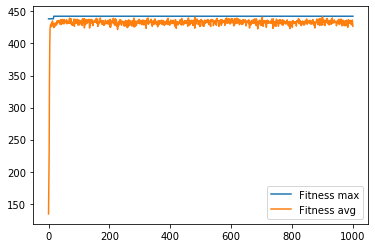

In [16]:
plt.plot([x["gen"] for x in logbook],[x["max"] for x in logbook], label="Fitness max")
plt.plot([x["gen"] for x in logbook],[x["avg"] for x in logbook], label="Fitness avg")
plt.legend()
plt.show()